File loaded successfully!

--- Basic Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452088 entries, 0 to 452087
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Date_of_journey    452088 non-null  object 
 1   Journey_day        452088 non-null  object 
 2   Airline            452088 non-null  object 
 3   Flight_code        452088 non-null  object 
 4   Class              452088 non-null  object 
 5   Source             452088 non-null  object 
 6   Departure          452088 non-null  object 
 7   Total_stops        452088 non-null  object 
 8   Arrival            452088 non-null  object 
 9   Destination        452088 non-null  object 
 10  Duration_in_hours  452088 non-null  float64
 11  Days_left          452088 non-null  int64  
 12  Fare               452088 non-null  int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 44.8+ MB

--- First 5 Rows ---
  Date_of_journey Jour

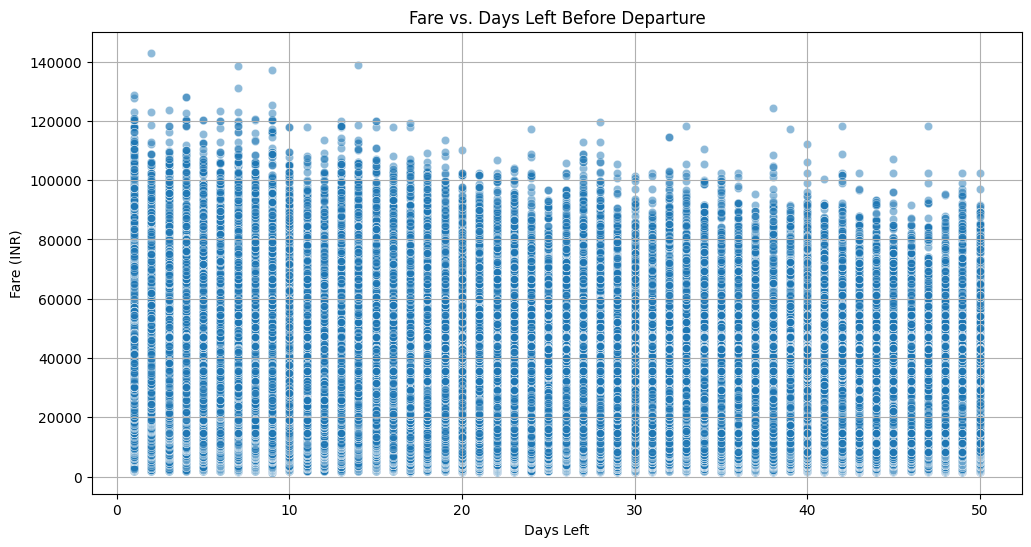

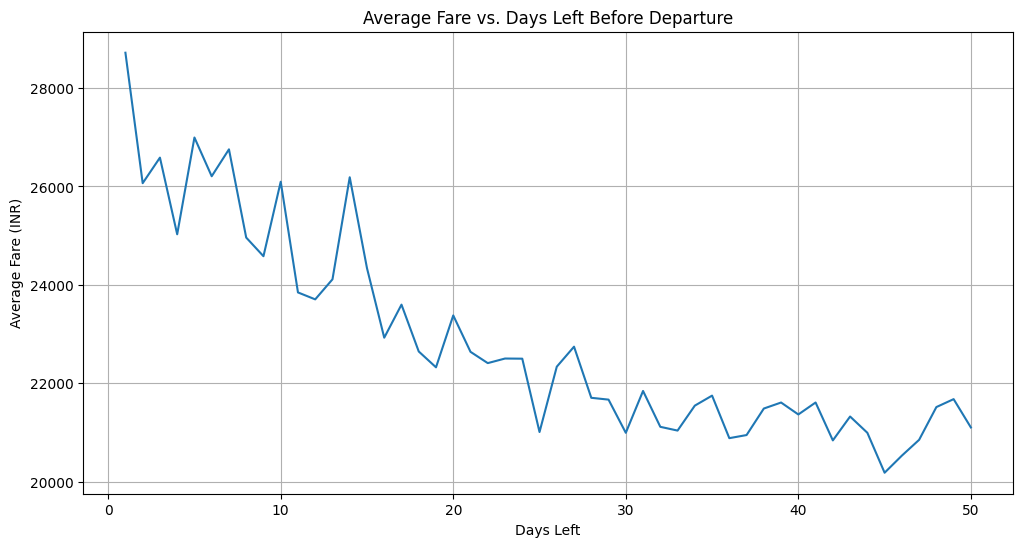


--- Data Exploration Complete ---


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

try:
    df = pd.read_csv('data/flight_dataset.csv') 
    print("File loaded successfully!")
except FileNotFoundError:
    print("ERROR: Could not find the CSV file. Check the path and filename in the 'data' folder.")

print("\n--- Basic Info ---")
df.info()
print("\n--- First 5 Rows ---")
print(df.head())
print("\n--- Shape (Rows, Columns) ---")
print(df.shape)

print("\n--- Statistics for Fare and Days_left ---")
print(df[['Fare', 'Days_left']].describe())

# Missing Values
print("\n--- Missing Values per Column ---")
print(df.isnull().sum())

plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Days_left', y='Fare', alpha=0.5)
plt.title('Fare vs. Days Left Before Departure')
plt.xlabel('Days Left')
plt.ylabel('Fare (INR)')
plt.grid(True)
plt.show()

if df['Days_left'].nunique() > 10: 
     avg_fare_by_days = df.groupby('Days_left')['Fare'].mean().reset_index()
     plt.figure(figsize=(12, 6))
     sns.lineplot(data=avg_fare_by_days, x='Days_left', y='Fare')
     plt.title('Average Fare vs. Days Left Before Departure')
     plt.xlabel('Days Left')
     plt.ylabel('Average Fare (INR)')
     plt.grid(True)
     plt.show()
else:
    print("\nNot enough unique 'Days_left' values to plot average fare reliably.")

print("\n--- Data Exploration Complete ---")

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split

# --- 1. Feature Engineering from Date and Time ---

# Convert 'Date_of_journey' to datetime objects
df['Date_of_journey'] = pd.to_datetime(df['Date_of_journey'], format='%Y-%m-%d') # Format seems correct based on head()

# Extract features like month and day of week
df['Journey_Month'] = df['Date_of_journey'].dt.month
df['Journey_DayOfWeek'] = df['Date_of_journey'].dt.dayofweek # Monday=0, Sunday=6

# Convert 'Departure' and 'Arrival' time bins into numerical order (approximate)
# You might refine this mapping based on actual time ranges if available
time_mapping = {'Before 6 AM': 0, '6 AM - 12 PM': 1, '12 PM - 6 PM': 2, 'After 6 PM': 3}
df['Departure_Num'] = df['Departure'].map(time_mapping)
df['Arrival_Num'] = df['Arrival'].map(time_mapping)

# Convert 'Total_stops' into numerical order
stop_mapping = {'non-stop': 0, '1-stop': 1, '2+-stop': 2, '2+-stops': 2} # Handling potential variation '2+-stops'
df['Total_stops_Num'] = df['Total_stops'].map(stop_mapping)

# Drop original columns that are now represented numerically or are less useful
df_processed = df.drop(['Date_of_journey', 'Journey_day', # Already captured day of week numerically
                       'Flight_code',     # Usually too specific for general price prediction
                       'Departure', 'Arrival', 'Total_stops'], axis=1)

print("\n--- DataFrame after initial feature engineering ---")
print(df_processed.head())
print("\nMissing values after mapping (should be 0 or very few):")
print(df_processed.isnull().sum()) # Check if any mappings failed

# Handle any rare NaNs created by mapping (if any)
df_processed.dropna(inplace=True)


# --- 2. Handle Remaining Categorical Features (One-Hot Encoding) ---

# Select remaining categorical columns
categorical_cols = ['Airline', 'Source', 'Destination', 'Class']

# Perform One-Hot Encoding
df_encoded = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)

print("\n--- DataFrame after One-Hot Encoding ---")
print(df_encoded.head())
print("\n--- Final Processed Shape ---")
print(df_encoded.shape)


# --- 3. Split Data ---

# Define features (X) and target (y)
X = df_encoded.drop('Fare', axis=1) # All columns except Fare
y = df_encoded['Fare']            # Only the Fare column

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\n--- Data Split Shapes ---")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

print("\n--- Data Preprocessing Complete ---")


--- DataFrame after initial feature engineering ---
     Airline    Class Source Destination  Duration_in_hours  Days_left  Fare  \
0   SpiceJet  Economy  Delhi      Mumbai             2.0833          1  5335   
1     Indigo  Economy  Delhi      Mumbai             2.3333          1  5899   
2   GO FIRST  Economy  Delhi      Mumbai             2.1667          1  5801   
3   SpiceJet  Economy  Delhi      Mumbai             2.0833          1  5794   
4  Air India  Economy  Delhi      Mumbai             2.1667          1  5955   

   Journey_Month  Journey_DayOfWeek  Departure_Num  Arrival_Num  \
0              1                  0              3            3   
1              1                  0              3            0   
2              1                  0              3            0   
3              1                  0              3            3   
4              1                  0              3            3   

   Total_stops_Num  
0                0  
1                0  


In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

print("--- Starting Model Training ---")

# Initialize the RandomForestRegressor model
# n_estimators=100 is a common starting point, random_state ensures reproducibility
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=20, min_samples_split=10)
# n_jobs=-1 uses all available CPU cores for faster training
# Added max_depth and min_samples_split for potentially better performance/less overfitting

# Train the model using the training data
model.fit(X_train, y_train)

print("--- Model Training Complete ---")

# --- Evaluate the Model ---
print("\n--- Evaluating Model Performance ---")

# Make predictions on the unseen test data
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

print("\n--- Evaluation Complete ---")

# Optional: Look at feature importances (which factors the model found most important)
try:
    importances = model.feature_importances_
    feature_names = X_train.columns
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

    print("\n--- Top 10 Feature Importances ---")
    print(feature_importance_df.head(10))
except Exception as e:
    print(f"\nCould not calculate feature importances: {e}")

--- Starting Model Training ---
--- Model Training Complete ---

--- Evaluating Model Performance ---
Mean Squared Error (MSE): 21397333.59
Root Mean Squared Error (RMSE): 4625.73
R-squared (R²): 0.95

--- Evaluation Complete ---

--- Top 10 Feature Importances ---
                  feature  importance
27          Class_Economy    0.508119
29  Class_Premium Economy    0.324681
0       Duration_in_hours    0.070294
1               Days_left    0.027725
14        Airline_Vistara    0.011960
4           Departure_Num    0.006558
5             Arrival_Num    0.006020
17           Source_Delhi    0.004337
3       Journey_DayOfWeek    0.004301
25    Destination_Kolkata    0.004251


In [ ]:
import joblib
import os

# Define the folder and filename for the model
model_filename = 'flight_fare_predictor.pkl'
model_path = os.path.join('.', model_filename) # Saves in the current (mlService) folder

# Save the trained model to a file
joblib.dump(model, model_path)

print(f"--- Model saved successfully to {model_path} ---")

In [10]:
print(X_train.columns.to_list())


['Duration_in_hours', 'Days_left', 'Journey_Month', 'Journey_DayOfWeek', 'Departure_Num', 'Arrival_Num', 'Total_stops_Num', 'Airline_AirAsia', 'Airline_AkasaAir', 'Airline_AllianceAir', 'Airline_GO FIRST', 'Airline_Indigo', 'Airline_SpiceJet', 'Airline_StarAir', 'Airline_Vistara', 'Source_Bangalore', 'Source_Chennai', 'Source_Delhi', 'Source_Hyderabad', 'Source_Kolkata', 'Source_Mumbai', 'Destination_Bangalore', 'Destination_Chennai', 'Destination_Delhi', 'Destination_Hyderabad', 'Destination_Kolkata', 'Destination_Mumbai', 'Class_Economy', 'Class_First', 'Class_Premium Economy']
